In [375]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Preprossesering av rentedataen
Ettersom dato-kolonnene er ulike for ulike rente-perioder så må vi først justere for dette.

In [376]:
df = pd.read_excel(r"20210922Renter.xlsx")
# data = df.to_numpy()

In [377]:
# computing number of rows
nrows = len(df.axes[0])
  
# computing number of columns
ncols = len(df.axes[1])

# number of series
nseries = int(ncols/2)

#insert columns in new dataframe
d = []
for j in range(0,nseries-1):
    d.append(df.iloc[:,2*j])                # legg til alle dato kolonner for hver serie i en ny liste d

dates = np.sort(np.unique(d))               # plukk ut unike datoer og sorter
dates = np.delete(dates,len(dates)-1)                            
df_final = pd.DataFrame(dates)
df_final.columns = ['dates']

# nseries er 14
for col in range(0,nseries-1):

    temp = np.zeros(nrows)
    
    # sjekk om  dato-kolonner er like eller ei
    if df.iloc[:,2*col].equals(df_final.iloc[:,0]): #2*col gir dato-kolonne i df
        
        df_final.insert(col+1 , df.columns[2*col+1] , df.iloc[:,2*col+1]) #2*col+1 gir verdi-kolonne i df
    
    else:
        # iterer radvis gjennom dato-kolonne som er ulik
        row_df = 0
        for row in range(0,nrows-1):                                         # finn hull i data-kolonnen

            if (df_final.iloc[row, 0] != df.iloc[row_df, 2*col]):            # hvis ulike datoer: bli stående å vente
                temp[row] = df.iloc[row_df-1, 2*col+1]                       # fyll inn med nærmeste rentedato bakover i tid på alle "tomme" dager  
            else:
                temp[row] = df.iloc[row_df, 2*col+1]                         # hvis like datoer
                row_df +=1   
                
        #legg temp inn df_final
        df_final.insert(col+1,df.columns[2*col+1], temp)
        

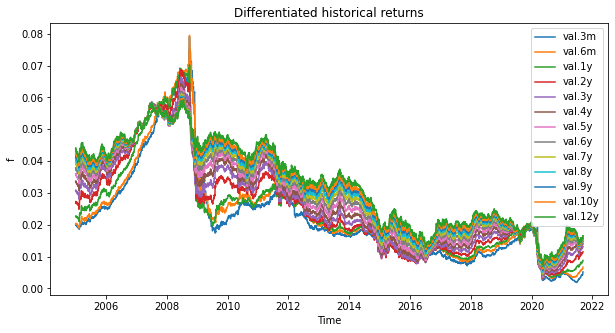

In [405]:
df_final = df_final.iloc[0:-2,:] #remove last row

#plot absolute returns
plt.figure(figsize=(10,5))
plt.plot(df_final.iloc[:,0], df_final.iloc[:,1:]/100 ,label=df_final.columns[1:])
plt.title('Differentiated historical returns')
plt.ylabel("f")
plt.xlabel("Time")
plt.legend()
plt.show()

#print(df_final) #mangler 15års renten...ups

## HJM framwork: Heath-Jarrow-Morton Model
Kode inspirert av: https://github.com/omartinsky/HJM/blob/main/hjm.ipynb

Modellerer forward interest rates ( =  en rate settes i dag for et lån som skal inngås i fremtiden.)

$$ df(t,T) = \alpha ( t, T ) dt + \sigma (t, T) dW(t) $$

hvor $df(t,T)$: forward rente på zero-copoun obligasjon med maturity T, og W er browniam motion (random walk).

$\alpha$ er drift-funksjon og $\sigma$ er volatilitetsfunksjon.

Den predikerer forward renter basert på summen av drift og diffusjon.



# Principal Component Analysis

The principal component analysis is then used to identify common factors which are driving movements in these rates. Typically 3-5 factors are sufficient to explain dynamics of the yield curve.

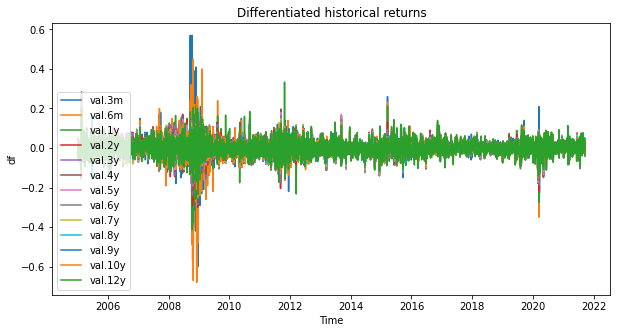

In [379]:
diff_rates = df_final.iloc[:,1:].diff( axis=0)
diff_rates = diff_rates.iloc[1:nrows-2,:] #delete first row

#plot absolute returns
plt.figure(figsize=(10,5))
plt.plot(df_returns.iloc[:,0], diff_rates, label=df_returns.columns[1:])
plt.title('Differentiated historical returns')
plt.ylabel("df")
plt.xlabel("Time")
plt.legend()
plt.show()

In [380]:
#tenor refers to the time-to-maturity of a loan or other financial contract.
tenors = [3/12,6/12,1,2,3,4,5,6,7,8,9,10,12]
print(tenors)

[0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]


In [381]:
# Calculate covariance matrix
sigma = np.cov(diff_rates.transpose())
print("Sigma shape : " + str(sigma.shape))

Sigma shape : (13, 13)


In [382]:
sigma *= 252 #annulize daily rates

In [383]:
#calculate eigenvalues and vectors
eigval, eigvec = np.linalg.eig(sigma)
eigvec=np.matrix(eigvec)
print(eigval)

[2.83786424 0.84407195 0.17261726 0.10690237 0.06958162 0.03731521
 0.02389587 0.01401507 0.01108018 0.00341763 0.00416149 0.00608959
 0.00799918]


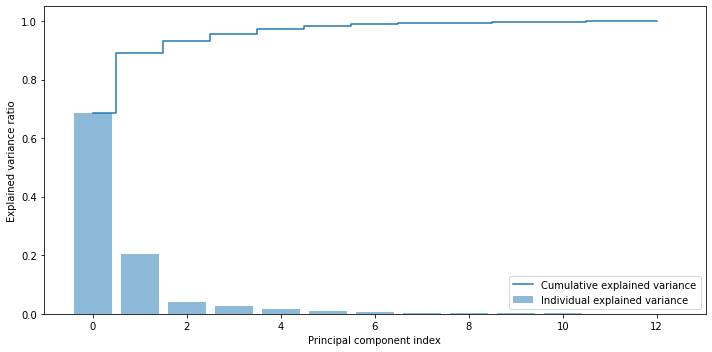

In [384]:
# Determine explained variance
total_eigval = sum(eigval)
var_exp = [(i/total_eigval) for i in sorted(eigval, reverse=True)]
var_exp

plt.figure(figsize=(10,5))
cum_sum_exp = np.cumsum(var_exp)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Principal eigenvalues
[2.83786424 0.84407195 0.17261726]

Principal eigenvectors
         1PC       2PC       3PC
0   0.130985 -0.628827  0.458275
1   0.155500 -0.600271  0.108864
2   0.189913 -0.325237 -0.445542
3   0.263291 -0.124658 -0.416540
4   0.291439 -0.044824 -0.351608
5   0.303930  0.021778 -0.223954
6   0.311619  0.066595 -0.101574
7   0.314653  0.100745  0.017604
8   0.313365  0.122697  0.115379
9   0.311245  0.138634  0.177479
10  0.309999  0.150050  0.205802
11  0.309905  0.152921  0.239653
12  0.304366  0.160284  0.277687


Text(0.5, 0, 'Time $t$')

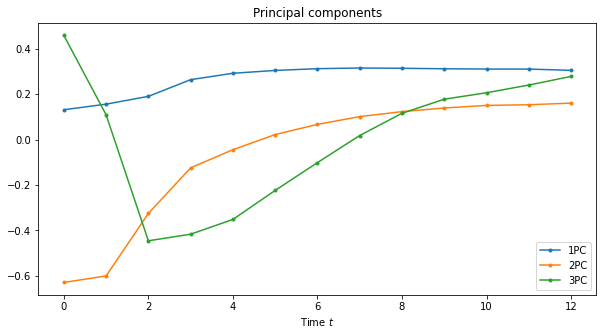

In [385]:
#select eigenvectors with highest eigenvalues
factors = 3 # 3 PCs
index_eigvec = list(reversed(eigval.argsort()))[0:factors]   # highest principal component first in the array
princ_eigval = np.array([eigval[i] for i in index_eigvec])
princ_comp = np.hstack([eigvec[:,i] for i in index_eigvec]) #hver PC eggges kolonnevis i princ_comp
princ_comp_df = pd.DataFrame(princ_comp, columns= ["1PC", "2PC", "3PC"])
#print results
print("Principal eigenvalues")
print(princ_eigval)
print()
print("Principal eigenvectors")
print(princ_comp_df)

#plot
plt.figure(figsize=(10,5))
plt.plot(princ_comp_df, marker='.', label=princ_comp_df.columns)
plt.title('Principal components')
plt.legend()
plt.xlabel(r'Time $t$')

vols shape: (13, 3)


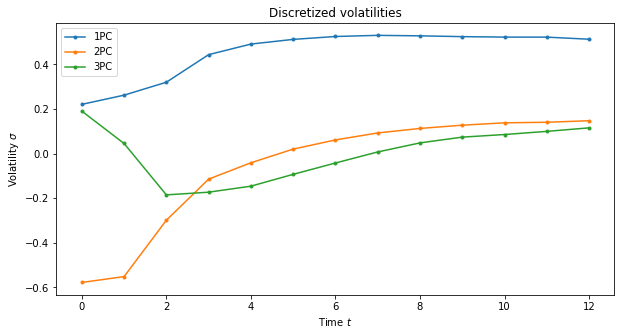

In [386]:
#Calculate discretized volatility function from principal components¶
sqrt_eigval = np.matrix(princ_eigval ** .5) #roten av egenverdier
tmp_m = np.vstack([sqrt_eigval for i in range(princ_comp.shape[0])])  # resize matrix og eigenvalues from (1,factors) to (n, factors)
vols = np.multiply(tmp_m, princ_comp) # multiply matrice element-wise
#vols_df = pd.DataFrame(vols, columns=["1PC", "2PC", "3PC"])

print('vols shape: ' + str(vols.shape))

#plot
plt.figure(figsize=(10,5))
plt.plot(vols, marker='.', label=princ_comp_df.columns)
plt.xlabel(r'Time $t$')
plt.ylabel(r'Volatility $\sigma$')
plt.legend()
plt.title('Discretized volatilities');

# Volatility Fitting

Once the volatility factors are identified in historical data by PCA technique, cubic spline interpolator is used to fit these factors. These interpolators are then later used to generate discrete mesh of tenors for the purpose of Monte Carlo simulation.

We need to fit discretized volatility functions from the previous step using cubic interpolators. The reason is that these interpolators will be later integrated numerically in order to calculate risk-neutral drift.

In [387]:
def get_matrix_column(mat, i): #return given column from matrix
    return np.array(mat[:,i].flatten())[0]

class PolynomialInterpolator:
    
    def __init__(self, params):
        self.params = params

    def calc(self, x):
        n = len(self.params)
        C = self.params
        X = np.array([x**i for i in reversed(range(n))]) #matrix of polynomials of x
        return sum(np.multiply(X, C)) 

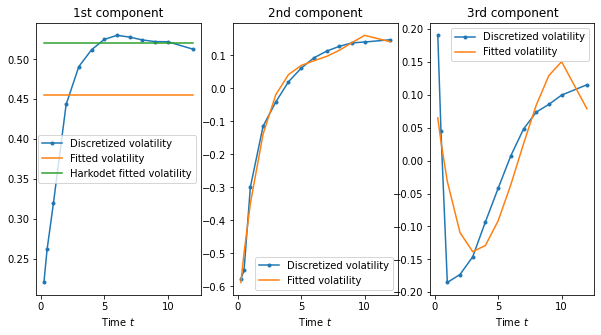

In [388]:
fitted_vols = []

def fit_volatility(i, degree, title): # i is giving index nr. of PC
    vol = get_matrix_column(vols, i)
    fitted_vol = PolynomialInterpolator(np.polyfit(tenors, vol, degree))        
    plt.plot(tenors, vol, marker='.', label='Discretized volatility')
    plt.plot(tenors, [fitted_vol.calc(x) for x in tenors], label='Fitted volatility')
    plt.title(title)
    plt.xlabel(r'Time $t$')
    plt.legend()
    return fitted_vol


plt.figure(figsize=(10,5))

# We will approximate the first principal component with interpolator with 0 degree (straight line). This approximates well parallel movements of interest rates.   
plt.subplot(1, 3, 1)
fit_volatility(0, 0, '1st component')
fitted_vol_try = PolynomialInterpolator([0.52])
fitted_vols.append(fitted_vol_try)

plt.plot(tenors, [fitted_vol_try.calc(x) for x in tenors], label='Harkodet fitted volatility')
plt.legend()

# 2nd and 3rd principal component will be approximated using cubic interpolator with degree 3.
plt.subplot(1, 3, 2)
fitted_vols.append(fit_volatility(1, 4, '2nd component'))

plt.subplot(1, 3, 3)
fitted_vols.append(fit_volatility(2, 3, '3rd component'))


# Risk-neutral Drift Calculation

Drift function is calculated using numerical integration over fitted volatility function.
Define function for numeric integration. We will use trapezoidal rule.

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
[[ 0.52       -0.68692995  0.10537258]
 [ 0.52       -0.34813019 -0.03158954]
 [ 0.52       -0.13834368 -0.10935562]
 [ 0.52       -0.0190881  -0.13833512]
 [ 0.52        0.04167758 -0.12893755]
 [ 0.52        0.06955308 -0.09157237]
 [ 0.52        0.08369688 -0.03664909]
 [ 0.52        0.09682614  0.02542282]
 [ 0.52        0.11521676  0.08423387]
 [ 0.52        0.13870334  0.12937458]
 [ 0.52        0.16067921  0.15043545]
 [ 0.52        0.1680964   0.137007  ]
 [ 0.52        0.14146568  0.07867976]]


Text(0.5, 1.0, 'Volatilities')

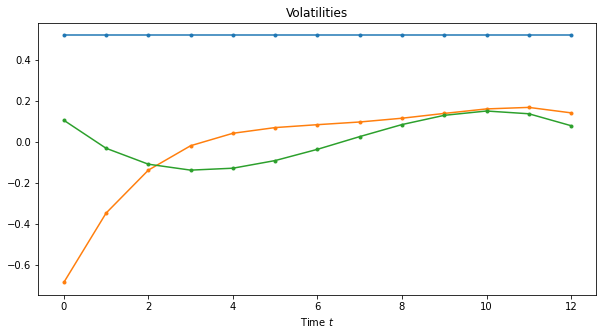

In [389]:
#make equally spaced points for xaxis
mc_tenors = np.linspace(0,12,len(tenors)) #equally spaced points giving the tenors
print(mc_tenors)

# Discretize fitted volfuncs for the purpose of monte carlo simulation
mc_vols = np.matrix([[fitted_vol.calc(tenor) for tenor in mc_tenors] for fitted_vol in fitted_vols]).transpose()
print(mc_vols)

plt.figure(figsize=(10,5))
plt.plot(mc_tenors, mc_vols, marker='.')
plt.xlabel(r'Time $t$')
plt.title('Volatilities')

In [390]:
def integrate(f, x0, x1, dx):
    n = (x1-x0)/dx+1
    out = 0
    for i, x in enumerate(np.linspace(x0, x1, int(n))):
        if i==0 or i==n-1:
            out += 0.5 * f(x)
        else:
            out += f(x)  # not adjusted by *0.5 because of repeating terms x1...xn-1 - see trapezoidal rule
    out *= dx
    return out


def m(tau, fitted_vols):
    #This funciton carries out integration for all principal factors. 
    #It uses the fact that volatility is function of time in HJM model
    out = 0.
    for fitted_vol in fitted_vols:
        out += integrate(fitted_vol.calc, 0, tau, 0.01) * fitted_vol.calc(tau)
    return out

Text(0.5, 1.0, 'Risk-neutral drift')

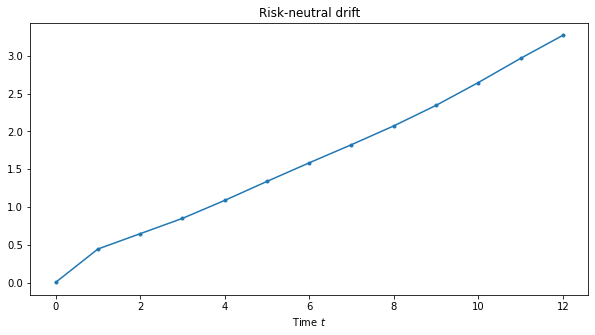

In [391]:
mc_drift = np.array([m(tau, fitted_vols) for tau in mc_tenors])

plt.figure(figsize=(10,5))
plt.plot(mc_drift, marker='.')
plt.xlabel(r'Time $t$')
plt.title('Risk-neutral drift')

# Monte Carlo Simulation

Monte Carlo Simulation with risk-neutral drift is used to generate evolution of yield curve for different simulation paths in order to price IR Caplet with strike 3%, expiring in one and maturing in two years.

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
[ 0.      0.01    0.      0.0125 -0.0075 -0.0075 -0.0275 -0.025  -0.03
 -0.0475 -0.0425 -0.0475 -0.05  ]


Text(0.5, 0, 'T (maturity date)')

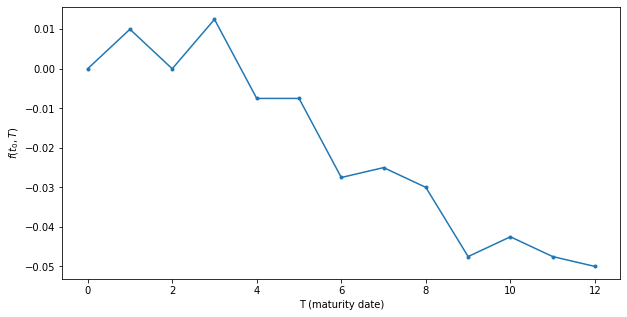

In [422]:
# finn start-forward rate for hver rente
print(mc_tenors)
f0 = np.array(np.matrix(diff_rates.iloc[0,:]).flatten())[0] #tar første element for å bli kvitt dobbel liste
print(f0)

plt.figure(figsize=(10,5))
plt.plot(mc_tenors, f0.transpose(), marker='.')
plt.ylabel('$f(t_0,T)$')
plt.xlabel("T (maturity date)")

In [419]:
import copy

def simulation(f, tenors, drift, vols, timeline):
    vols = np.array(vols.transpose())  # 3 rows, T columns
    len_tenors = len(tenors)
    len_vols = len(vols)
    yield timeline[0], copy.copy(f)

    for it in range(1, len(timeline)):                  # for hver x-verdi (dato i fremtiden)
        t = timeline[it]                                # t er ant. år frem i tid.
        dt = t - timeline[it-1]                         # tidsintervall fra sist iterasjon
        sqrt_dt = np.sqrt(dt)
        fprev = f
        f = copy.copy(f)
        random_numbers = [np.random.normal() for i in range(len_vols)] #dX_i er std.normal fordelt og vi har 3 stk ( = #PC)

        for iT in range(len_tenors):                        
            val = fprev[iT] + drift[iT] * dt #hent ut første del av df + f
            #
            summ = 0
            for iVol, vol in enumerate(vols): #iterer gj. sum av volatiliteter
                summ += vol[iT] * random_numbers[iVol] #random_numbers gir dX_i
            val += summ * sqrt_dt #legg til siste ledd på df + f – brownian motion er std.normal*swrt(dt)
            #

            #når man er i slutten av tids-skalaen
            iT1 = iT+1 if iT < len_tenors-1 else iT-1   # if we can't take right difference, take left difference
            
            dfdT = (fprev[iT1] - fprev[iT]) / (iT1 - iT) #Musela HJM SDE 
            val += dfdT * dt
            #
            f[iT] = val
        yield t,f

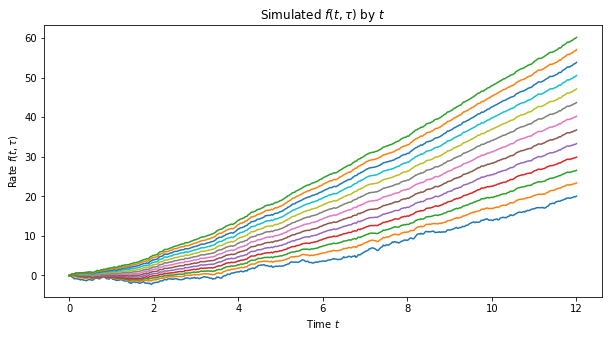

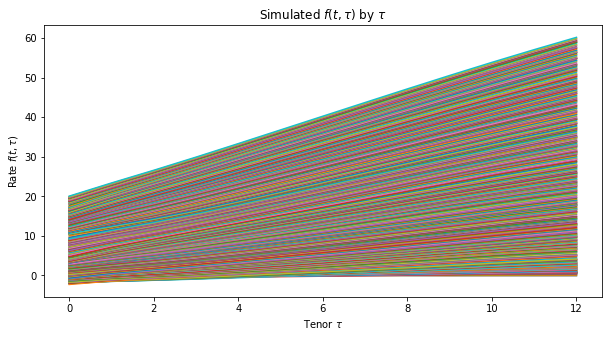

In [421]:
proj_rates = []
proj_timeline = np.linspace(0,12,500)

for i, (t, f) in enumerate(simulation(f0, mc_tenors, mc_drift, mc_vols, proj_timeline)):
    proj_rates.append(f)

proj_rates = np.matrix(proj_rates)


plt.figure(figsize=(10,5))
plt.plot(proj_timeline.transpose(), proj_rates)
plt.xlabel(r'Time $t$')
plt.ylabel(r'Rate $f(t,\tau)$')
plt.title(r'Simulated $f(t,\tau)$ by $t$')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(mc_tenors, proj_rates.transpose())
plt.xlabel(r'Tenor $\tau$')
plt.ylabel(r'Rate $f(t,\tau)$')
plt.title(r'Simulated $f(t,\tau)$ by $\tau$')
plt.show()


#start dato???
# forstå monte carlo koden!!